In [73]:
#import required libraries
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset, WeightedRandomSampler
from torchvision import transforms
import pytorch_lightning as pl
from torchmetrics import Accuracy
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, f1_score
from imblearn.over_sampling import ADASYN

# Set random seeds for reproducibility
def set_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.labels_df.iloc[idx, 0]}.png")
        image = Image.open(img_name).convert("RGB")
        label = self.labels_df.iloc[idx, 1]
        patient_id = self.labels_df.iloc[idx, 0]

        if self.transform:
            image = self.transform(image)

        return image, label


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


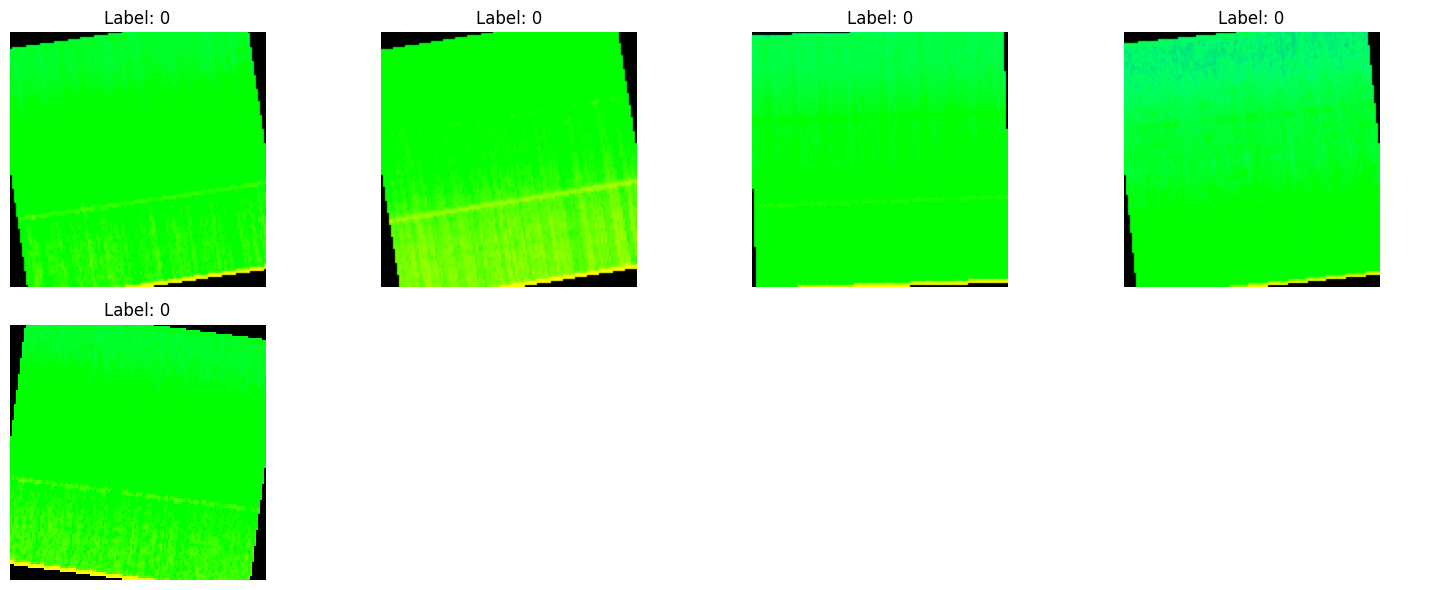

In [74]:
# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize based on ImageNet
    transforms.RandomHorizontalFlip(),  # Add data augmentation
    transforms.RandomRotation(10)  # Add data augmentation
])

dataset = CustomImageDataset(csv_file='image/label.csv', img_dir='image/all', transform=transform)


# Fetch the first 5 images and their labels
first_5_images_labels = [dataset[i] for i in range(5)]

# Display in a grid
rows = 2  # Number of rows in the grid
cols = 4  # Number of columns in the grid

# Calculate the number of images to display (ensure it's within the available images)
num_images_to_display = min(len(first_5_images_labels), rows * cols)


# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 6))  # Adjust figsize for grid size

for i, ax in enumerate(axes.flat):
    if i < num_images_to_display:
        image, label = first_5_images_labels[i]

        # Ensure image is in correct format (H, W, C) and in range [0, 1] for display

        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide empty subplots if you have fewer than rows * cols images

plt.tight_layout()
plt.show()

In [76]:
X = np.array([sample[0] for sample in dataset])
y = np.array([sample[1] for sample in dataset])
#patient_ids = np.array([sample[2] for sample in dataset])
print(y)
print(y.shape)

[0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(246,)


In [80]:
import torch.nn as nn
import torch.nn.functional as F


class ParallelCNN(nn.Module):
    def __init__(self, num_classes=1):  
        super(ParallelCNN, self).__init__()

        # Branch 1 (filter size 1)
        self.conv_branch1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=1, padding=0), # Assuming input channels = 3 (RGB)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4, 4))  # Adaptive pooling to ensure same output size
        )

        # Branch 2 (filter size 2)
        self.conv_branch2 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4, 4))  # Adaptive pooling to ensure same output size
        )

        # Fully Connected Layer
        self.fc = nn.Sequential(
            nn.Linear(256 * 4 * 4 * 2, 512),  # Adjusted input size
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # Output for your number of classes
        )

    def forward(self, x):
        out1 = self.conv_branch1(x)
        out2 = self.conv_branch2(x)
        out = torch.cat([out1, out2], dim=1)  # Concatenate along the channel dimension
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc(out)
        return out

# Instantiate the model
#model = ParallelCNN()


In [81]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return torch.mean(F_loss)

In [82]:
from torch.optim import Adam

 ##Train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):


   
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        model.eval()
  
        val_loss = 0.0


        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels.unsqueeze(1).float())
                val_loss += loss.item() * images.size(0)

  

        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)


        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        #Check model output statistics
        with torch.no_grad():
            sample_outputs = model(images)
            print(f'Sample outputs: {torch.sigmoid(sample_outputs).cpu().numpy().flatten()[:5]}')
  
        


In [83]:
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch[:2]
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy().flatten()
            y_pred.extend(preds>0.5)
            y_true.extend(labels.cpu().numpy().flatten())
            loss = criterion(outputs, labels.unsqueeze(1).float())
            test_loss += loss.item() * images.size(0)
            
    threshold = 0.4
    y_pred = np.round(y_pred).astype(int)

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')
    return y_true, y_pred



In [85]:
def sampler_generator(dataset):
    # Get the class distribution for the dataset
    labels = [label.item() for _,label in dataset]
    class_counts = np.bincount(labels)
    # Ensure there are no zero counts to avoid division by zero
    class_counts = np.clip(class_counts, 1, None)

    # Calculate the class weights inversely proportional to class frequencies
    total_samples = len(labels)
    class_weights = total_samples / (len(class_counts) * class_counts)
    class_weights /= class_weights.sum()  # Normalize the weights

    # Apply weights to samples based on their labels
    samples_weights = np.array([class_weights[label] for label in labels])
    return WeightedRandomSampler(samples_weights, len(samples_weights))

In [86]:
# Function to compute a combined metric of precision and recall for both labels
def combined_metric(label, report):
    return (report[label]['precision'] + report[label]['recall'] ) / 2

In [87]:
# Function to train and test the model
def run_experiment():
    
    set_seeds(42)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_val_indices, test_indices = next(skf.split(X, y))

    skf_train_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_indices, val_indices = next(skf_train_val.split(X[train_val_indices], y[train_val_indices]))

    #train_rs_X , train_rs_y =  adasyn(X[train_indices],y[train_indices],beta=1,K=10)

    train_X = X[train_indices]
    train_y = y[train_indices]


    
    train_X_flattened = train_X.reshape(train_X.shape[0], -1) 


    adasyn = ADASYN(sampling_strategy='auto', random_state=42)
    train_rs_X, train_rs_y = adasyn.fit_resample(train_X_flattened, train_y)

    train_rs_X = train_rs_X.reshape(train_rs_X.shape[0], 3, 128, 128)

    train_rs_X = torch.tensor(train_rs_X).float()
    train_rs_y = torch.tensor(train_rs_y).long()  # Use long type for labels

    train_dataset = TensorDataset(train_rs_X,train_rs_y )



    #train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)

    train_sampler = sampler_generator(train_dataset)

    # Create DataLoaders for each subset
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    # Define model, criterion, optimizer
    model = ParallelCNN()
    criterion = FocalLoss(alpha=0.75, gamma=2)
    optimizer = Adam(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = 10
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

    # Test the model
    y_true, y_pred = test_model(model, test_loader, criterion)
    
    return y_true, y_pred, classification_report(y_true, y_pred, output_dict=True)

# Number of times to run the experiment
num_experiments = 2

# Initialize variables to store the best results for each label
best_report_label_0 = None
best_report_label_1 = None
best_y_true_label_0 = None
best_y_pred_label_0 = None
best_y_true_label_1 = None
best_y_pred_label_1 = None
best_metric_value_label_0 = -1
best_metric_value_label_1 = -1

for i in range(num_experiments):
    y_true, y_pred, report = run_experiment()
    
    metric_value_label_0 = combined_metric('0', report)
    metric_value_label_1 = combined_metric('1', report)
    
    if metric_value_label_0 > best_metric_value_label_0:
        best_metric_value_label_0 = metric_value_label_0
        best_report_label_0 = report
        best_y_true_label_0 = y_true
        best_y_pred_label_0 = y_pred
        
    if metric_value_label_1 > best_metric_value_label_1:
        best_metric_value_label_1 = metric_value_label_1
        best_report_label_1 = report
        best_y_true_label_1 = y_true
        best_y_pred_label_1 = y_pred



Epoch 1/10, Train Loss: 0.6999, Val Loss: 0.2272
Sample outputs: [0.6221459  0.62205195 0.6215371  0.6225689  0.629441  ]
Epoch 2/10, Train Loss: 0.2223, Val Loss: 0.1420
Sample outputs: [0.5207249  0.5264349  0.5174932  0.533569   0.51415604]
Epoch 3/10, Train Loss: 0.1618, Val Loss: 0.1308
Sample outputs: [0.48619792 0.4547159  0.45804006 0.48241913 0.4818126 ]
Epoch 4/10, Train Loss: 0.1577, Val Loss: 0.1370
Sample outputs: [0.51467997 0.46694982 0.43547216 0.46828926 0.47432783]
Epoch 5/10, Train Loss: 0.1197, Val Loss: 0.1777
Sample outputs: [0.63158286 0.5007525  0.53869694 0.5240769  0.5572891 ]
Epoch 6/10, Train Loss: 0.1109, Val Loss: 0.2960
Sample outputs: [0.74185395 0.66264904 0.66693735 0.6898906  0.72084725]
Epoch 7/10, Train Loss: 0.0963, Val Loss: 0.1254
Sample outputs: [0.73677146 0.14462931 0.42738062 0.21646684 0.7231113 ]
Epoch 8/10, Train Loss: 0.0996, Val Loss: 0.2512
Sample outputs: [0.7577207  0.55812925 0.49728763 0.632897   0.77909815]
Epoch 9/10, Train Loss: 

c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Confusion Matrix:


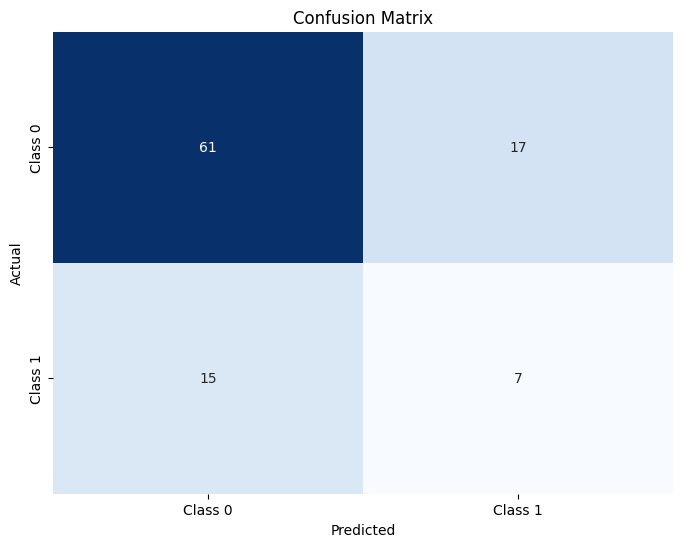

Test Accuracy: 0.6800
Best Classification Report for Label 0 and Label 1:
{'0': {'precision': 0.78, 'recall': 1.0, 'f1-score': 0.8764044943820225, 'support': 39}, '1': {'precision': 0.2916666666666667, 'recall': 0.6363636363636364, 'f1-score': 0.4, 'support': 11}, 'accuracy': 0.78, 'macro avg': {'precision': 0.39, 'recall': 0.5, 'f1-score': 0.43820224719101125, 'support': 50}, 'weighted avg': {'precision': 0.6084, 'recall': 0.78, 'f1-score': 0.6835955056179777, 'support': 50}}


In [88]:

# Visualize the confusion matrix for the best results
print("Confusion Matrix:")
best_y_true = np.concatenate((best_y_true_label_0, best_y_true_label_1))
best_y_pred = np.concatenate((best_y_pred_label_0, best_y_pred_label_1))
cm = confusion_matrix(best_y_true, best_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print the accuracy for the best results
accuracy = accuracy_score(best_y_true, best_y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

# Combine the best reports into one
combined_report = best_report_label_0.copy()
combined_report['1'] = best_report_label_1['1']

# Print the best classification report
print("Best Classification Report for Label 0 and Label 1:")
print(combined_report)